### Imports

In [124]:
import pickle
from copy import deepcopy

import cv2 as cv
import numpy as np
import os
import time

from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC

In [125]:
class Parameters:
    def __init__(self):
        self.dir_save_files = "resources/salveazaFisiere"
        self.dim_hog_cell = 8
        self.number_negative_examples = 0
        self.number_positive_examples = 0

### Functii luate de la laborator

In [126]:
def intersection_over_union(bbox_a, bbox_b):
    x_a = max(bbox_a[0], bbox_b[0])
    y_a = max(bbox_a[1], bbox_b[1])
    x_b = min(bbox_a[2], bbox_b[2])
    y_b = min(bbox_a[3], bbox_b[3])

    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

    box_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
    box_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

### Redimensionez fetele din imaginile de antrenare la aceeasi dimensiune si le transform in tonuri gri pentru a putea antrena clasificatorul liniar

In [127]:
# ### Am cautat o medie de w si h in setul de date al lui louie pentru a sti la ce masura sa redimensionez fete fara sa pierd foarte mult continut si o sa iau dimensiunea unui patrat scalat la ratia 4:3
#
# path = "resources/antrenare/louie/"
# f = open("resources/antrenare/louie_annotations.txt")
# lines = f.readlines()
#
# vector_w_fete = []
# vector_h_fete = []
#
# for line in lines:
#     info = line.split(" ")
#     nume_imagine = info[0]
#     xmin = int(info[1])
#     ymin = int(info[2])
#     xmax = int(info[3])
#     ymax = int(info[4])
#     nume_personaj = info[5][:-1]
#
#     img = cv.imread(path + nume_imagine)
#     if nume_personaj == "louie":
#         w = xmax - xmin
#         h = ymax - ymin
#
#         vector_w_fete.append(w)
#         vector_h_fete.append(h)
#
# vector_w_fete = np.array(vector_w_fete)
# print(f"medie{vector_w_fete.mean()}\n"
#       f"min{vector_w_fete.min()}\n"
#       f"max{vector_w_fete.max()}")
#
# vector_h_fete = np.array(vector_h_fete)
# print(f"medie{vector_h_fete.mean()}\n"
#       f"min{vector_h_fete.min()}\n"
#       f"max{vector_h_fete.max()}")
#
#

### Calculez descriptorii pt imaginile pozitive

In [128]:
def line_info(line):
    info = line.split(" ")
    nume_imagine = info[0]
    xmin = int(info[1])
    ymin = int(info[2])
    xmax = int(info[3])
    ymax = int(info[4])
    nume_personaj = info[5][:-1]
    return nume_imagine, xmin, ymin, xmax, ymax, nume_personaj

In [129]:

def get_descriptors_of_image(nume_imagine_anterioara, faces_of_image, path):
    img = cv.imread(path + nume_imagine_anterioara, cv.IMREAD_GRAYSCALE)
    pos_descriptors = []
    neg_descriptors = []
    # print(nume_imagine_anterioara)
    # print(faces_of_image)
    for y in range(0, img.shape[0] - ydim_face_img, 30):
        for x in range(0, img.shape[1] - xdim_face_img, 30):

            for face_box in faces_of_image:

                iou = intersection_over_union(face_box, (x, y, x + xdim_face_img, y + ydim_face_img))
                # print(iou)
                crop_img = img[y:y + ydim_face_img, x:x + xdim_face_img]

                features = hog(crop_img,
                           pixels_per_cell=(dim_hog_cell, dim_hog_cell),
                           cells_per_block=(2, 2),
                           # visualize=True,
                           feature_vector=True)
                # flip_features  = hog(np.fliplr(crop_img),
                #                      pixels_per_cell=(dim_hog_cell, dim_hog_cell),
                #                      cells_per_block=(2, 2),
                #                      feature_vector=True)
                # print(len(features))
                if iou > 0.5:
                    # cv.imshow("imghog", img_hog)
                    # cv.imshow("original", crop_img)
                    # cv.waitKey(0)
                    # cv.destroyAllWindows()
                    pos_descriptors.append(features)
                    # pos_descriptors.append(flip_features)
                else:
                    # cv.imshow("original", crop_img)
                    # cv.waitKey(0)
                    # cv.destroyAllWindows()
                    neg_descriptors.append(features)
                    # neg_descriptors.append(flip_features)
    return pos_descriptors, neg_descriptors

In [130]:

# folosind fereastra glisanta, trecem peste fiecare imagine de la stanga la dreapta de sus in jos si cu ajutorul iou, clasificam daca fereastra contine o fata sau nu asfel adaugam un descriptor pozitiv sau negativ
# intai creez un vector cu pozitiile fetelor dintr-o imagine, iar in momentul in care o imagine nu mai are fete caut descriptorii
def get_descriptors(nume_personaj):
    positive_descriptors = []
    negative_descriptors = []
    path = "resources/antrenare/" + nume_personaj + "/"
    f = open("resources/antrenare/" + nume_personaj + "_annotations.txt")
    lines = f.readlines()
    nume_imagine_anterioara = lines[0].split(" ")[0]
    faces_of_image = []
    time_start = time.time()
    lines = lines
    lines.append("end0 1 2 3 4 end5\n")
    print(nume_imagine_anterioara)
    for line in lines:
        nume_imagine, xmin, ymin, xmax, ymax, nume_personaj = line_info(line)
        if nume_imagine != nume_imagine_anterioara:

            positive_descriptors_of_image, negative_descriptors_of_image = get_descriptors_of_image(nume_imagine_anterioara, faces_of_image, path)
            positive_descriptors.extend(positive_descriptors_of_image)

            if len(negative_descriptors) < 1000:
                negative_descriptors.extend(negative_descriptors_of_image)

            print(f"time for img{nume_imagine_anterioara} -> {time.time() - time_start}")
            time_start = time.time()

            nume_imagine_anterioara = nume_imagine
            faces_of_image = [[xmin, ymin, xmax, ymax]]
        else:
            faces_of_image.append((xmin, ymin, xmax, ymax))

        print(f"imagini pozitive = {len(positive_descriptors)}")
        print(f"imagini negative = {len(negative_descriptors)}")

    positive_descriptors = np.array(positive_descriptors)
    negative_descriptors = np.array(negative_descriptors)

    return positive_descriptors, negative_descriptors


In [131]:
def train_classifier(params, training_examples, train_labels):
    svm_file_name = os.path.join(params.dir_save_files, 'best_model_%d_%d_%d' %
                                 (params.dim_hog_cell, params.number_negative_examples,
                                  params.number_positive_examples))
    if os.path.exists(svm_file_name):
        best_model = pickle.load(open(svm_file_name, 'rb'))
        return

    best_accuracy = 0
    best_c = 0
    best_model = None
    Cs = [10 ** -5, 10 ** -4,  10 ** -3,  10 ** -2, 10 ** -1, 10 ** 0]
    for c in Cs:
        print('Antrenam un clasificator pentru c=%f' % c)
        model = LinearSVC(C=c)
        model.fit(training_examples, train_labels)
        acc = model.score(training_examples, train_labels)
        print(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_c = c
            best_model = deepcopy(model)

    print('Performanta clasificatorului optim pt c = %f' % best_c)
    # salveaza clasificatorul
    pickle.dump(best_model, open(svm_file_name, 'wb'))

    # vizualizeaza cat de bine sunt separate exemplele pozitive de cele negative dupa antrenare
    # ideal ar fi ca exemplele pozitive sa primeasca scoruri > 0, iar exemplele negative sa primeasca scoruri < 0
    scores = best_model.decision_function(training_examples)
    best_model = best_model
    positive_scores = scores[train_labels > 0]
    negative_scores = scores[train_labels <= 0]


    plt.plot(np.sort(positive_scores))
    plt.plot(np.zeros(len(negative_scores)))
    plt.plot(np.sort(negative_scores))
    plt.xlabel('Nr example antrenare')
    plt.ylabel('Scor clasificator')
    plt.title('Distributia scorurilor clasificatorului pe exemplele de antrenare')
    plt.legend(['Scoruri exemple pozitive', '0', 'Scoruri exemple negative'])
    plt.show()

Construim descriptorii pentru exemplele pozitive si negative:
0001.jpg
imagini pozitive = 0
imagini negative = 0
time for img0001.jpg -> 0.8779995441436768
imagini pozitive = 0
imagini negative = 88
imagini pozitive = 0
imagini negative = 88
time for img0002.jpg -> 1.3419983386993408
imagini pozitive = 5
imagini negative = 259
time for img0003.jpg -> 0.67403244972229
imagini pozitive = 5
imagini negative = 347
time for img0004.jpg -> 0.6589672565460205
imagini pozitive = 10
imagini negative = 430
time for img0005.jpg -> 0.6440324783325195
imagini pozitive = 16
imagini negative = 512
time for img0006.jpg -> 0.6559736728668213
imagini pozitive = 22
imagini negative = 594
time for img0007.jpg -> 0.6690261363983154
imagini pozitive = 27
imagini negative = 677
time for img0008.jpg -> 0.6610028743743896
imagini pozitive = 31
imagini negative = 761
time for img0009.jpg -> 0.6500086784362793
imagini pozitive = 38
imagini negative = 842
time for img0010.jpg -> 0.6789882183074951
imagini pozitiv

C:\Users\allex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9988920895191669
Performanta clasificatorului optim pt c = 0.100000


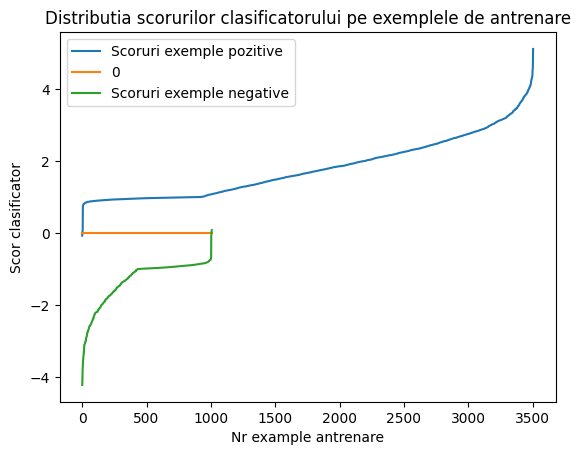

In [132]:
# dimensiunea ferestrei
params: Parameters = Parameters()
xdim_face_img = 160 # exemplele pozitive (fetele de oameni cropate) cu 160x120 pixeli
ydim_face_img = 120
dim_hog_cell = 8 # dimensiunea celului
positive_descriptors = np.array([])
negative_descriptors = np.array([])

# Pasul 1,2,3 -> Incarcam exemplele pozitive si exemplele negative
# Verificam daca acestea sunt existente, daca nu for fi create
# nume_personaje = ["andy", "louie", "ora", "tommy"]
nume_personaje = ["louie"]
for nume_personaj in nume_personaje:
    dir_save_files = "resources\salveazaFisiere"
    positive_descriptors_path = os.path.join(dir_save_files, 'descriptoriExemplePozitive_' + nume_personaj +'_'+
                                             str(dim_hog_cell) + '_' + '.npy')
    negative_descriptors_path = os.path.join(dir_save_files, 'descriptoriExempleNegative_' + nume_personaj +'_'+
                                             str(dim_hog_cell) + '_' + '.npy')

    if os.path.exists(positive_descriptors_path) and os.path.exists(negative_descriptors_path):
        positive_descriptors = np.load(positive_descriptors_path)
        negative_descriptors = np.load(negative_descriptors_path)
        print(f'Am incarcat descriptorii pentru exemplele pozitive si negative pentru {nume_personaj}')
    else:
        print('Construim descriptorii pentru exemplele pozitive si negative:')
        positive_descriptors, negative_descriptors = get_descriptors(nume_personaj)
        np.save(positive_descriptors_path, positive_descriptors)
        np.save(negative_descriptors_path, negative_descriptors)
        print('Am salvat descriptorii pentru exemplele pozitive in fisierul %s' % positive_descriptors_path)
        print('Am salvat descriptorii pentru exemplele negative in fisierul %s' % negative_descriptors_path)

# Pasul 4 - > Invatam clasificatorul liniar

number_positive_examples = len(positive_descriptors)
number_negative_examples = len(negative_descriptors)

print(f"numarul de imagini pozitive -> {number_positive_examples}")
print(f"numarul de imagini negative -> {number_negative_examples}")

training_examples = np.concatenate((np.squeeze(positive_descriptors), np.squeeze(negative_descriptors)), axis=0)
train_labels = np.concatenate((np.ones(number_positive_examples), np.zeros(number_negative_examples)))
train_classifier(params, training_examples, train_labels)

### TESTAREEEEEEEEEEEE

In [133]:
# img = cv.imread("resources/antrenare/louie/0001.jpg", cv.IMREAD_GRAYSCALE)
# features, hog_img  = hog(img,
#                pixels_per_cell=(8, 8),
#                cells_per_block=(2, 2),
#                feature_vector=True,
#                 visualize=True)
# cv.imshow("imghog", hog_img)
# cv.waitKey(0)
# cv.destroyAllWindows()


In [134]:
list2 = [[7, 8, 9], [10, 11, 12]]

result = []
result.extend(list2)

print(result)

[[7, 8, 9], [10, 11, 12]]
